<a href="https://colab.research.google.com/github/rakshitgupta22/fake-real-news/blob/main/train_Bert_Liar_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1_ifPR5akPuic4YkIg0piuuDX6M4beStX'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.tsv')

downloaded = drive.CreateFile({'id':'1PhnGw5RHn77UFEly5PGmjYeAQtTAp6c8'})
downloaded.GetContentFile('test.tsv')

downloaded = drive.CreateFile({'id':'1S-DiGvh7NNokkpbPvBwbG9dzFLs4S2Qt'})
downloaded.GetContentFile('valid.tsv')

In [ ]:
import pandas as pd

In [ ]:
data_train = pd.read_csv("train.tsv", sep = "\t", header = None)
data_valid = pd.read_csv("valid.tsv", sep = "\t", header = None)
data_test = pd.read_csv("test.tsv", sep = "\t", header = None)

In [ ]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
data_train[1].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: 1, dtype: int64

In [ ]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]]
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]

      speaker =  dataset[4][i]

      job =  dataset[5][i]

      state =  dataset[6][i]

      affiliation =  dataset[7][i]

      context =  dataset[13][i]

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column

  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [ ]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train = data_preprocessing(data_train)
data_valid = data_preprocessing(data_valid)
data_test = data_preprocessing(data_test)

In [ ]:
#Sample data after preprocessing
data_train.head()

,label,sentence
0,0,abortion dwayne-bohac State representative Tex...
1,0,"energy,history,job-accomplishments scott-surov..."
2,1,foreign-policy barack-obama President Illinois...
3,0,health-care blog-posting nan nan none a news r...
4,0,"economy,jobs charlie-crist nan Florida democra..."


In [ ]:
print(data_train.shape)
print(data_valid.shape)
print(data_test.shape)

(10240, 2)
(1284, 2)
(1267, 2)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00


In [ ]:
#importing required packages
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW)

In [ ]:
# Loading BERT base model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", #Using BERT base model with an uncased vocab.
                                                                num_labels = 2, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                          )
#BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()

"""# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
                                                                    num_labels = 2,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()"""

print(' Base models loaded')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

 Base models loaded


In [ ]:
#assigning sentences and labels to separate variables
sentences = data_train["sentence"].values
labels = data_train["label"].values

<AxesSubplot:>

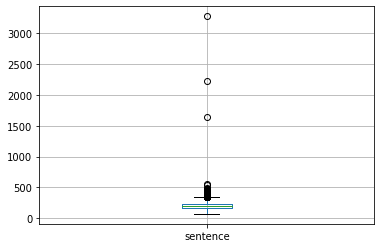

In [ ]:
sentence_length = pd.DataFrame(data_train['sentence'].apply(lambda x : len(x)))
sentence_length.boxplot()

In [ ]:
sentence_length.describe()

,sentence
count,10240.000000
mean,204.759473
std,66.961203
min,68.000000
25%,165.000000
50%,198.000000
75%,236.000000
max,3279.000000


In [ ]:
import torch

In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = dataset["sentence"].values
  labels = dataset["label"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids
      bert_encoded_dict = bert_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,     #Since we have seen from our analysis that majority of sentences have length less than 300.
                          pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      """roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.
                          pad_to_max_length = True,     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )"""


      # Add the encoded sentence to the list.
      bert_input_ids.append(bert_encoded_dict['input_ids'])
      #roberta_input_ids.append(roberta_encoded_dict['input_ids'])


      # Add attention mask to the list
      bert_attention_masks.append(bert_encoded_dict['attention_mask'])
      #roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])


      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1



  # Convert the lists into tensors.
  bert_input_ids = torch.cat(bert_input_ids, dim=0)
  bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

  # roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  # roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {"Bert":[bert_input_ids, bert_attention_masks, labels], "Roberta":""#[roberta_input_ids, roberta_attention_masks, labels]
          }

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(data_train)

bert_input_ids,bert_attention_masks,labels = token_dict_train["Bert"]
# roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(data_valid)

bert_input_ids_valid,bert_attention_masks_valid,labels_valid = token_dict_valid["Bert"]
# roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(data_test)

bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
# roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Combine the training inputs into a TensorDataset.
bert_train_dataset = TensorDataset( bert_input_ids, bert_attention_masks, labels)
# roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
bert_val_dataset = TensorDataset(bert_input_ids_valid,bert_attention_masks_valid,labels_valid)
# roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

In [ ]:
# Combine the test inputs into a TensorDataset.
bert_test_dataset = TensorDataset(bert_input_ids_test,bert_attention_masks_test,labels_test)
# roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

"""roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )"""

# Create the DataLoaders for our validation - Loads the data in batches of size 32
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


"""roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )"""

'roberta_validation_dataloader = DataLoader(\n            roberta_val_dataset, # The validation samples.\n            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.\n            batch_size = batch_size # Evaluate with this batch size.\n        )'

In [ ]:
# optimizers - AdamW
# here, i have used default learning rate and epsilon values for both BERT and RoBERTa
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

# roberta_optimizer = AdamW(roberta_model.parameters(),
#                   lr = 5e-5,
#                   eps = 1e-8
#                 )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer,
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
      #Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # print current training batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        bert_model.zero_grad()

        outputs = bert_model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # model returns a tuple, extract loss value from that tuple
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()

        bert_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    #Validation Part


    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode
    bert_model.eval()
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
           outputs = bert_model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:51.
  Batch    80  of    320.    Elapsed: 0:01:43.
  Batch   120  of    320.    Elapsed: 0:02:35.
  Batch   160  of    320.    Elapsed: 0:03:26.
  Batch   200  of    320.    Elapsed: 0:04:18.
  Batch   240  of    320.    Elapsed: 0:05:09.
  Batch   280  of    320.    Elapsed: 0:06:01.

  Average training loss: 0.64
  Training epcoh took: 0:06:52

Running Validation...
  Accuracy: 0.69
  Validation took: 0:00:19

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    320.    Elapsed: 0:00:51.
  Batch    80  of    320.    Elapsed: 0:01:43.
  Batch   120  of    320.    Elapsed: 0:02:35.
  Batch   160  of    320.    Elapsed: 0:03:26.
  Batch   200  of    320.    Elapsed: 0:04:18.
  Batch   240  of    320.    Elapsed: 0:05:09.
  Batch   280  of    320.    Elapsed: 0:06:01.

  Average training loss: 0.56
  Training epcoh took: 0:06:52

Running Validation...
  Accuracy: 0.69
  Validation took: 0:00:1

In [ ]:
bert_prediction_sampler = SequentialSampler(bert_test_dataset)
bert_prediction_dataloader = DataLoader(bert_test_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables
predictions , true_labels = [], []

Predicting labels for 1,267 test sentences...


In [ ]:
# Predict
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

    DONE.


              precision    recall  f1-score   support

           0       0.79      0.74      0.77       878
           1       0.49      0.57      0.53       389

    accuracy                           0.69      1267
   macro avg       0.64      0.65      0.65      1267
weighted avg       0.70      0.69      0.69      1267



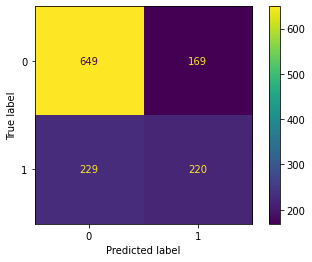

In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print (classification_report(predictions_labels, flat_true_labels))
cm_test = confusion_matrix(flat_true_labels, predictions_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()

In [ ]:
bert_model.save_pretrained("/content/drive/MyDrive/RA/bert-liar-pt")
bert_tokenizer.save_pretrained("/content/drive/MyDrive/RA/bert-liar-pt-tokenizer")

('/content/drive/MyDrive/RA/bert-liar-pt-tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/RA/bert-liar-pt-tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/RA/bert-liar-pt-tokenizer/vocab.txt',
 '/content/drive/MyDrive/RA/bert-liar-pt-tokenizer/added_tokens.json')

In [ ]:
LIAR_dataset_full = pd.concat([data_train, data_valid, data_test], keys=['train','valid','test'], names=['data','row'], axis=0).reset_index().drop('row', axis=1)

12791

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(LIAR_dataset_full)))

#tokenizing test set
token_dict = bert_robert_tokenization(LIAR_dataset_full)

bert_input_ids,bert_attention_masks,labels = token_dict["Bert"]

# Combine the test inputs into a TensorDataset.
bert_dataset = TensorDataset(bert_input_ids,bert_attention_masks,labels)

bert_prediction_sampler = SequentialSampler(bert_dataset)
bert_prediction_dataloader = DataLoader(bert_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
bert_model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch


  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

Predicting labels for 12,791 test sentences...


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



    DONE.


In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()

In [ ]:
LIAR_dataset_full['predictions'] = predictions_labels

In [ ]:
LIAR_dataset_full = LIAR_dataset_full[['sentence', 'label', 'predictions']].rename(columns={"label":"true_label"})

In [ ]:
LIAR_dataset_full.head(10)

,sentence,true_label,predictions
0,abortion dwayne-bohac State representative Tex...,0,0
1,"energy,history,job-accomplishments scott-surov...",0,0
2,foreign-policy barack-obama President Illinois...,1,1
3,health-care blog-posting nan nan none a news r...,0,0
4,"economy,jobs charlie-crist nan Florida democra...",0,0
5,education robin-vos Wisconsin Assembly speaker...,1,1
6,candidates-biography republican-party-texas na...,0,0
7,ethics barack-obama President Illinois democra...,0,0
8,jobs oregon-lottery nan nan organization a web...,0,0
9,"energy,message-machine-2014,voting-record duey...",1,0


In [ ]:
LIAR_dataset_full.to_csv("/content/drive/MyDrive/RA/LIAR_dataset_full_predictions.tsv", sep="\t", index=False)